**J. Behler and M. Parrinello, Generalized Neural-Network Representation of High-Dimensional Potential-Energy Surfaces, PRL 98, 146401 (2007)**

In [2]:
from math import exp, pow, sqrt, tanh, pi, cos, acos, ceil
import matplotlib.pyplot as plt
from typing import Sequence, Tuple
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import TensorDataset, DataLoader, random_split
import pytorch_lightning as pl
import numpy as np
import random
import itertools
from pytorch_lightning import loggers as pl_loggers
from sklearn.model_selection import train_test_split
import math
import sys
torch.set_default_dtype(torch.float64)

In [3]:
#Load data 
# Here We need coords in qm and mm; Energy and atom_type


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # set device
print(device)
device = torch.device( "cpu") # set device

Energy = (torch.from_numpy(np.array(np.load("LOGA.npy"), dtype="float64"))*1.364).to(device) #[Num_config]
descriptor = torch.from_numpy(np.array(np.load("Feature.npy"), dtype="float64"))#QM_coord [Num_config,Num_atom,3(xyz)]
Num_Feature=len(descriptor[0,0])#30
Num_atom=len(descriptor[0])     #40
Num_config=len(descriptor)      #128
atom_types = torch.from_numpy(np.array(np.load("type.npy"), dtype="float64")) #Atom_type [Num_atom_all] as "C=6,H=1,O=8"
elems = np.unique(atom_types).tolist()
print(elems)
atom_types = torch.from_numpy(np.array([elems.index(i) for i in atom_types[:Num_atom]])).to(device)
atom_types = atom_types.repeat(len(Energy), 1).long() # [Num_config,Num_atom_all]

Num_config  = len(Energy)

# Scheme to split dataset 

train_ratio = 0.8      # 95% data to train
validation_ratio = 0.2 #  5% data for validation

Num_train = int(Num_config * train_ratio) # Number of training set
Num_valid= Num_config-Num_train


descriptor=descriptor.reshape(-1,Num_atom*Num_Feature).to(device)
#.to(device)

cpu
[5.0, 6.0, 7.0]


In [4]:
#Feature

pl.seed_everything(2)
dataset = TensorDataset(descriptor, atom_types, Energy)
train, val = random_split(dataset, [98, 30])
loader_train = DataLoader(train, batch_size=10)
loader_valid = DataLoader(val, batch_size=32)

#
dataset1 = TensorDataset(descriptor[:98], atom_types[:98], Energy[:98])
dataset2 = TensorDataset(descriptor[98:], atom_types[98:], Energy[98:])
loader_train = DataLoader(dataset1, batch_size=10)
loader_valid = DataLoader(dataset2, batch_size=32)

Global seed set to 2


In [5]:
#training process
class PlNeuralNet(pl.LightningModule):
    def __init__(self, n_net=3, n0=30, n1=15,atom_types=atom_types, lr=1.e-2):
        super().__init__()
        subnets = []
        for i_net in range(n_net):
            subnet = nn.Sequential(
                nn.Linear(n0, n1),
                nn.Tanh(),
                nn.Linear(n1, 1)
            )
            subnets.append(subnet)
            
        self.model = nn.ModuleList(subnets)
        self.learning_rate = lr
        self.atom_types=atom_types

    def forward(self, x):    
        b_size, n_atom = x.shape
        atomic_E = torch.zeros((b_size, n_atom//Num_Feature)).to(device)
        for i_atom in range(Num_atom):
            i_subnet = self.atom_types[0,i_atom]
            atomic_E[:,i_atom] = torch.flatten(self.model[i_subnet](x[:,Num_Feature*i_atom:Num_Feature*(i_atom+1)]))
        Eout  = atomic_E.sum(axis=1)
        return Eout

    def training_step(self, batch, batch_idx):
        
        xy,atom_types, z = batch
        z_pred = self(xy)
        lossfn = nn.MSELoss()
        loss = lossfn(z_pred.squeeze(), z)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        xy,atom_types, z = batch
        z_pred = self(xy)
        lossfn = nn.MSELoss()
        lossval = lossfn(z_pred.squeeze(), z)
        self.log('valloss', lossval)
        return lossval
    
    def test_step(self, batch, batch_idx):
        xy,atom_types, z = batch
        z_pred = self(xy)
        lossfn = nn.MSELoss()
        losstest = lossfn(z_pred.squeeze(), z)
        self.log('testloss', losstest)
        return losstest
    

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        scheduler = {'scheduler': torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.97),
                     'interval': 'epoch',
                     'frequency': 5,
                    }
        return [optimizer] #, [scheduler]

In [6]:
from pytorch_lightning.callbacks import ModelCheckpoint   
num_epochs = 300

checkpoint_callback = ModelCheckpoint(save_top_k = -1, save_last = False, every_n_epochs = 10)#100 epochs to save once 
csv_logger = pl_loggers.CSVLogger('logs_csv/', flush_logs_every_n_steps = 10)
trainer = pl.Trainer(max_epochs = num_epochs, log_every_n_steps = 10, logger = csv_logger, callbacks = [checkpoint_callback], accelerator = "cpu")

Num_element=3
n1 = Num_Feature // 2
n_net = Num_element
print(n_net)
learning_rate = 3.e-2
print('n1=',n1)
model = PlNeuralNet(n_net, Num_Feature, n1,atom_types, learning_rate)

trainer.fit(model, loader_train, loader_valid)
#trainer.validate(dataloaders = loader_valid, ckpt_path = 'best')


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params
-------------------------------------
0 | model | ModuleList | 1.4 K 
-------------------------------------
1.4 K     Trainable params
0         Non-trainable params
1.4 K     Total params
0.006     Total estimated model params size (MB)


3
n1= 15


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\wjn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:236: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\wjn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:236: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=300` reached.


In [13]:
#print param

for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
    #print(param_tensor, "\t", model.state_dict()[param_tensor])

model.0.0.weight 	 torch.Size([15, 30])
model.0.0.bias 	 torch.Size([15])
model.0.2.weight 	 torch.Size([1, 15])
model.0.2.bias 	 torch.Size([1])
model.1.0.weight 	 torch.Size([15, 30])
model.1.0.bias 	 torch.Size([15])
model.1.2.weight 	 torch.Size([1, 15])
model.1.2.bias 	 torch.Size([1])
model.2.0.weight 	 torch.Size([15, 30])
model.2.0.bias 	 torch.Size([15])
model.2.2.weight 	 torch.Size([1, 15])
model.2.2.bias 	 torch.Size([1])


Text(0, 0.5, 'Errors')

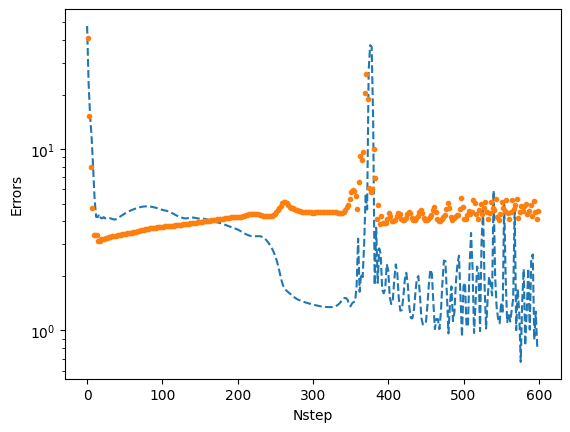

In [7]:
#plot 
import pandas as pd
loss_pack = pd.read_csv("logs_csv/lightning_logs/version_3/metrics.csv")
loss_valid = loss_pack.valloss.dropna()
loss_train = loss_pack.train_loss.dropna()


fig, ax = plt.subplots()
ax.semilogy(loss_train,'--',loss_valid,'.')
#ax.plot(loss_train,'--',loss_valid,'.')
ax.set_xlabel("Nstep")
ax.set_ylabel("Errors")

In [36]:

#chk="C:\JP\github_bpnn\TEST-AGAB\logs_csv\lightning_logs/version_2\checkpoints\epoch=89-step=900.ckpt"
#model=PlNeuralNet(n_net, Num_Feature, 30,atom_types, learning_rate).load_from_checkpoint(chk)

[[1.         0.58939755]
 [0.58939755 1.        ]]
[[1.         0.03484338]
 [0.03484338 1.        ]]


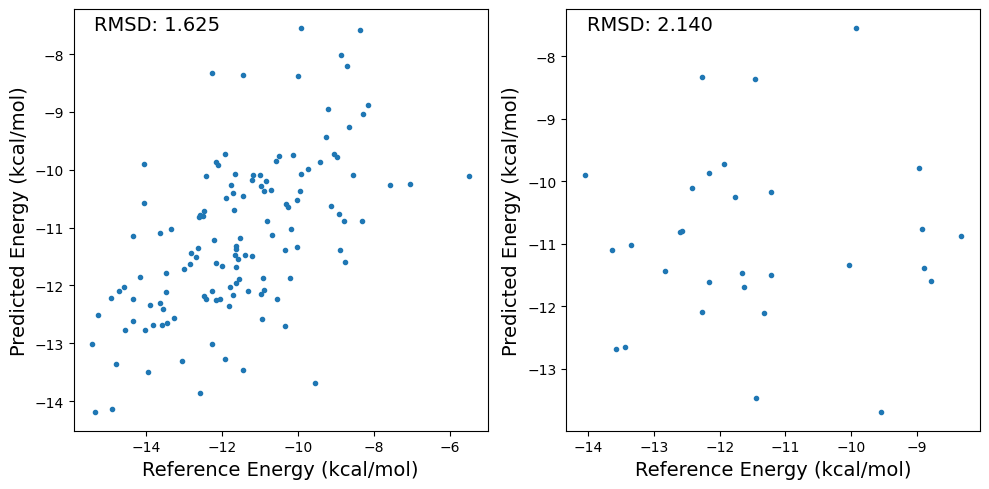

In [9]:
import matplotlib.pyplot as plt

e2=model.forward(descriptor).detach().numpy()
fig, ax = plt.subplots(1,2,figsize=(10,5))

e1 = Energy.cpu().detach().numpy()
Coef=np.corrcoef(e1,e2)
print(Coef)

ax[0].plot(e1, e2, linestyle='none', marker='.', )
#ax[0].plot([np.max(np.concatenate((e1,e2))), -np.max(np.concatenate((e1,e2)))], [np.max(np.concatenate((e1,e2))), -np.max(np.concatenate((e1,e2)))], color="k", linewidth=1.5)
ax[0].set_xlabel("Reference Energy (kcal/mol)", size=14)
ax[0].set_ylabel("Predicted Energy (kcal/mol)", size=14)
ax[0].annotate('RMSD: %.3f' % np.sqrt(np.mean((e1 - e2)**2)), xy=(0.05, 0.95), xycoords='axes fraction', size=14)


e2=model.forward(descriptor[98:]).detach().numpy()
e1 = Energy[98:].cpu().detach().numpy()
Coef=np.corrcoef(e1,e2)
print(Coef)
ax[1].plot(e1, e2, linestyle='none', marker='.', )
#ax[1].plot([np.max(np.concatenate((e1,e2))), -np.max(np.concatenate((e1,e2)))], [np.max(np.concatenate((e1,e2))), -np.max(np.concatenate((e1,e2)))], color="k", linewidth=1.5)
ax[1].set_xlabel("Reference Energy (kcal/mol)", size=14)
ax[1].set_ylabel("Predicted Energy (kcal/mol)", size=14)
ax[1].annotate('RMSD: %.3f' % np.sqrt(np.mean((e1 - e2)**2)), xy=(0.05, 0.95), xycoords='axes fraction', size=14)
plt.tight_layout()
plt.savefig('rmsd.png', dpi=300)

In [25]:
class NeuralNetwork(nn.Module):
    def __init__(self, n_net=1, n0=3, n1=10):  #n1 is the number of neurons for the first layer
        super().__init__()
        subnets = []
        for i_net in range(n_net):
            subnet = nn.Sequential(
                nn.Linear(n0, n1),
                nn.Tanh(),
#                nn.Linear(n1, n1),
#                nn.Tanh(),
                nn.Linear(n1, 1)
            )
            subnets.append(subnet)
        self.model = nn.ModuleList(subnets)

    def forward(self, x):
        b_size, n_atom = x.shape
        atomic_E = torch.zeros((b_size, n_atom//Num_Feature)).to(device)
        for i_atom in range(Num_atom):
            i_subnet = atom_types[0,i_atom]
            atomic_E[:,i_atom] = torch.flatten(self.model[i_subnet](x[:,Num_Feature*i_atom:Num_Feature*(i_atom+1)]))
        Eout  = torch.sum(atomic_E, axis = 1)
        return Eout

def train_loop(dataloader, model, lossfn, optimizer, i_epoch):
    size = len(dataloader.dataset)
    for batch, (input_feature, target) in enumerate(dataloader):
        pred = model(input_feature)   # call model.forward()
        loss = lossfn(pred.squeeze(), target)
    
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch+1 == ceil(len(dataloader.dataset)/DLparams['batch_size']) and i_epoch % 10 == 0:
            loss, current = loss.item(), batch * len(input_feature)
            print(f"epoch: {i_epoch:>4d} loss: {loss:>7.3f}  [{current:>5d}/{size:>5d}]")

In [26]:
# Training of Machine Learning Model
learning_rate = 3e-2
num_epochs = 100
n_net = Num_element
n1 = Num_Feature // 2
model = NeuralNetwork(n_net, Num_Feature, n1).to(device)
lossfn = nn.MSELoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
#optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1.E-5)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.97)

for i_epoch in range(num_epochs):
    train_loop(loader_train, model, lossfn, optimizer, i_epoch)
    scheduler.step()
    
print("Done with Training!")

epoch:    0 loss:   4.591  [  480/  800]
epoch:   10 loss:   1.380  [  480/  800]
epoch:   20 loss:   0.769  [  480/  800]
epoch:   30 loss:   0.702  [  480/  800]
epoch:   40 loss:   0.583  [  480/  800]
epoch:   50 loss:   0.500  [  480/  800]
epoch:   60 loss:   0.628  [  480/  800]
epoch:   70 loss:   0.634  [  480/  800]
epoch:   80 loss:   0.442  [  480/  800]
epoch:   90 loss:   0.461  [  480/  800]
Done with Training!
